### In this script, we will be creating new features and selecting features that are relevant for daily-level data. We will then drop the less relevant hourly features and focus on daily granularity.

In [20]:
import pandas as pd
import numpy as np
import holidays
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

df_final = pd.read_csv('5) final_merged_data_imputed.csv', parse_dates=['timestamp'])
print(df_final.columns)

Index(['household_id', 'timestamp', 'consumption', 'tariff',
       'washing_machine_fixed_schedule', 'tumble_dryer_fixed_schedule',
       'dishwasher_fixed_schedule', 'immersion_water_heater_fixed_schedule',
       'electric_oven_fixed_schedule', 'electric_hob_fixed_schedule',
       'ironing_fixed_schedule', 'electric_shower_fixed_schedule',
       'kettle_fixed_schedule', 'lighting_fixed_schedule',
       'electric_heater_fixed_schedule', 'washer-dryer_combined_timer_use',
       'washing_machine_timer_use', 'tumble_dryer_timer_use',
       'dishwasher_timer_use', 'electric_space_heating_timer_use',
       'washer-dryer_combined_ownership', 'washing_machine_ownership',
       'tumble_dryer_ownership', 'dishwasher_ownership',
       'electric_space_heating_ownership', 'household_size', 'male_occupants',
       'female_occupants', 'count_children', 'count_adult', 'ownership_owned',
       'ownership_rented', 'ownership_other', 'work_from_home',
       'housing_house', 'housing_apartm

In [21]:
# First, let's drop 'housing_mobile' (mutually exclusive, one-hot encoded variable) to avoid multicollinearity
df_final.drop('housing_mobile', axis=1, inplace=True)

### Functions to create new features

In [22]:
def create_daily_features(df):
    df['date'] = df['timestamp'].dt.date

    # Find the timestamp of peak consumption for each day
    peak_times = df.loc[df.groupby(['household_id', 'date'])['consumption'].idxmax()]
    peak_times = peak_times[['household_id', 'date', 'timestamp', 'temp', 'humidity', 'windspeed', 'precip', 'solarradiation', 'tariff']]
    
    # Map tariff values to categorical labels
    tariff_mapping = {0.0399: 0, 0.1176: 1, 0.6720: 2}
    peak_times['tariff'] = peak_times['tariff'].map(tariff_mapping)
    
    peak_times.columns = ['household_id', 'date', 'peak_time'] + [f'{col}_at_peak_consumption_today' for col in ['temp', 'humidity', 'windspeed', 'precip', 'solarradiation']] + ['tariff_at_peak_consumption_today']

    # Aggregate daily data
    daily_agg = df.groupby(['household_id', 'date']).agg({
    'consumption': ['sum', 'max', 'min'], 
    'temp': ['min', 'max', 'mean'],
    'humidity': ['min', 'max', 'mean'],
    'windspeed': ['mean', 'max', 'min'], 
    'precip': 'sum',
    'solarradiation': 'sum'
    })

    # Flatten column names
    daily_agg.columns = ['_'.join(col).strip() for col in daily_agg.columns.values]
    daily_agg.reset_index(inplace=True)

    daily_agg.rename(columns={
        'consumption_sum': 'consumption_sum_today',
        'consumption_max': 'consumption_peak_today',
        'consumption_min': 'consumption_min_today',
        'temp_min': 'temp_min_today',
        'temp_max': 'temp_max_today',
        'temp_mean': 'temp_mean_today',
        'humidity_min': 'humidity_min_today',
        'humidity_max': 'humidity_max_today',
        'humidity_mean': 'humidity_mean_today',
        'windspeed_mean': 'windspeed_mean_today',
        'windspeed_max': 'windspeed_max_today',
        'windspeed_min': 'windspeed_min_today',
        'precip_sum': 'precip_sum_today',
        'solarradiation_sum': 'solarradiation_sum_today'
    }, inplace=True)

    # Create price features
    price_features = df.groupby(['household_id', 'date', 'tariff']).size().unstack(fill_value=0)
    price_features.reset_index(inplace=True)

    # Rename price duration columns
    price_features = price_features.rename(columns={
        0.0399: 'low_price_duration',
        0.1176: 'normal_price_duration',
        0.6720: 'high_price_duration'
    })

    # Merge aggregated data with price features and peak time features
    daily_df = daily_agg.merge(price_features, on=['household_id', 'date'])
    daily_df = daily_df.merge(peak_times, on=['household_id', 'date'])

    # Identify the first day for each household since the first day only has entries for 23 hours
    daily_df['is_first_day'] = daily_df.groupby('household_id')['date'].transform('min') == daily_df['date']

    # Set denominator for proportion calculation (23 for first day, 24 for all other days)
    daily_df['hours_denominator'] = np.where(daily_df['is_first_day'], 23, 24)

    # Create proportions for prices
    for price_str in ['low', 'normal', 'high']:
        daily_df[f'prop_{price_str}_price'] = daily_df[f'{price_str}_price_duration'] / daily_df['hours_denominator']

    # Drop temporary and unnecessary columns
    columns_to_drop = ['is_first_day', 'hours_denominator', 'low_price_duration', 'normal_price_duration', 'high_price_duration']
    daily_df = daily_df.drop(columns=columns_to_drop)

    # Create consumption_peak_next_day feature
    daily_df['consumption_peak_next_day'] = daily_df.groupby('household_id')['consumption_peak_today'].shift(-1)

    return daily_df

def add_features(df):
    print("Initial shape:", df.shape)

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date', 'household_id'])

    # Previous day's peak consumption
    df['prev_day_peak'] = df.groupby('household_id')['consumption_peak_today'].shift(1)

    # Peak consumption from same day last week
    df['same_day_last_week_peak'] = df.groupby('household_id')['consumption_peak_today'].shift(7)

    # Average peak consumption over past 3 and 7 days
    df['avg_peak_3d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=3).mean().reset_index(0, drop=True)
    df['avg_peak_7d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=7).mean().reset_index(0, drop=True)

    # For weekly patterns
    df['day_of_week'] = df['date'].dt.dayofweek

    # Maximum of daily peak consumption over past 7 days and 3 days
    df['max_peak_7d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=7).max().reset_index(0, drop=True)
    df['max_peak_3d'] = df.groupby('household_id')['consumption_peak_today'].rolling(window=3).max().reset_index(0, drop=True)

    # Daily temperature range
    df['temp_range_today'] = df['temp_max_today'] - df['temp_min_today']

    # Season (for London)
    def get_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'
        else:
            return 'Winter'
    df['season'] = df['date'].dt.month.map(get_season)

    # Create binary variables for each season (one-hot encoding). Exclude spring to avoid multicollinearity.
    df['is_summer'] = (df['season'] == 'Summer').astype(int)
    df['is_autumn'] = (df['season'] == 'Autumn').astype(int)
    df['is_winter'] = (df['season'] == 'Winter').astype(int)

    # Weekend and holiday indicators
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    uk_holidays = holidays.UK(years=2013)
    df['is_holiday'] = df['date'].isin(uk_holidays).astype(int)

    # Day of week sine and cosine transformation
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Week of month calculation
    df['week_of_month'] = df['date'].apply(lambda x: (x.day - 1) // 7 + 1)

    # Week of month sine and cosine transformation
    df['week_of_month_sin'] = np.sin(2 * np.pi * df['week_of_month'] / 4)
    df['week_of_month_cos'] = np.cos(2 * np.pi * df['week_of_month'] / 4)

    # Remove temporary columns
    df = df.drop(['day_of_week', 'week_of_month', 'peak_time', 'season'], axis=1)
    
    # Final sort
    df = df.sort_values(['date', 'household_id'])
    
    print("Final shape:", df.shape)
    print("Final columns:", df.columns)
    
    return df


In [23]:
# Create the daily DataFrame
daily_df = create_daily_features(df_final)

print("Shape before daily_features:", daily_df.shape)

print("Columns after create_daily_features:")
print(daily_df.columns)
print("Shape after daily features:", daily_df.shape)

result_df = add_features(daily_df) 

print("Column names after add features:")
print(list(result_df.columns))
print("Shape after add_features:", result_df.shape)

Shape before daily_features: (221920, 27)
Columns after create_daily_features:
Index(['household_id', 'date', 'consumption_sum_today',
       'consumption_peak_today', 'consumption_min_today', 'temp_min_today',
       'temp_max_today', 'temp_mean_today', 'humidity_min_today',
       'humidity_max_today', 'humidity_mean_today', 'windspeed_mean_today',
       'windspeed_max_today', 'windspeed_min_today', 'precip_sum_today',
       'solarradiation_sum_today', 'peak_time',
       'temp_at_peak_consumption_today', 'humidity_at_peak_consumption_today',
       'windspeed_at_peak_consumption_today',
       'precip_at_peak_consumption_today',
       'solarradiation_at_peak_consumption_today',
       'tariff_at_peak_consumption_today', 'prop_low_price',
       'prop_normal_price', 'prop_high_price', 'consumption_peak_next_day'],
      dtype='object')
Shape after daily features: (221920, 27)
Initial shape: (221920, 27)
Final shape: (221920, 42)
Final columns: Index(['household_id', 'date', 'consu

In [24]:
# List of columns to exclude from static characteristics
exclude_columns = ['household_id', 'timestamp', 'tariff', 'consumption', 
                   'temp', 'humidity', 'windspeed', 'precip', 'solarradiation']

# Create a dataframe of static characteristics with one row per household
static_columns = [col for col in df_final.columns if col not in exclude_columns and col not in result_df.columns]
static_df = df_final[['household_id'] + static_columns].drop_duplicates(subset=['household_id'])

# Verify that static_df has the correct number of rows
print("Number of rows in static_df:", len(static_df))

# Merge with static household characteristics
result_df = result_df.merge(static_df, on='household_id', how='left')

# Ensure final sorting
result_df = result_df.sort_values(['date', 'household_id'])

# After merge
print("Number of unique households after merge:", result_df['household_id'].nunique())
print("Number of rows after merge:", len(result_df))
print("Number of duplicate household_id entries:", result_df.duplicated(subset=['household_id', 'date']).sum())
print("Shape of result_df:", result_df.shape)

print(result_df.columns)
print(result_df.shape)
print("\nColumns with NaN values:")
print(result_df.isnull().sum()[result_df.isnull().sum() > 0])

Number of rows in static_df: 608
Number of unique households after merge: 608
Number of rows after merge: 221920
Number of duplicate household_id entries: 0
Shape of result_df: (221920, 104)
Index(['household_id', 'date', 'consumption_sum_today',
       'consumption_peak_today', 'consumption_min_today', 'temp_min_today',
       'temp_max_today', 'temp_mean_today', 'humidity_min_today',
       'humidity_max_today',
       ...
       'count_energy_saving_devices', 'count_tv', 'tv_energy_score',
       'smart_meter_interaction_score', 'interest_in_renewable_energy',
       'interest_in_microgeneration', 'climate_change_concern',
       'lifestyle_environment', 'smart_meter_bill_understanding',
       'smart_meter_consumption_understanding'],
      dtype='object', length=104)
(221920, 104)

Columns with NaN values:
consumption_peak_next_day     608
prev_day_peak                 608
same_day_last_week_peak      4256
avg_peak_3d                  1216
avg_peak_7d                  3648
max_pea

### We will remove the days with missing values due to the creation of lagged variables and next day's peak consumption.

In [25]:
rows_before = result_df.shape[0]
# Remove rows with NaN values
result_df = result_df.dropna()
rows_after = result_df.shape[0]

# Calculate the number of rows removed
rows_removed = rows_before - rows_after

# Print the number of rows removed (It should be 4864, which is 4256 + 608)
print(f"Number of rows removed due to NaN values: {rows_removed}")

Number of rows removed due to NaN values: 4864


### Next, we will convert the data type of variables to more appropriate ones.

In [26]:
pd.set_option('display.max_rows', None)
print("\nData types of each variable:")
print(result_df.dtypes)


Data types of each variable:
household_id                                        object
date                                        datetime64[ns]
consumption_sum_today                              float64
consumption_peak_today                             float64
consumption_min_today                              float64
temp_min_today                                     float64
temp_max_today                                     float64
temp_mean_today                                    float64
humidity_min_today                                 float64
humidity_max_today                                 float64
humidity_mean_today                                float64
windspeed_mean_today                               float64
windspeed_max_today                                float64
windspeed_min_today                                float64
precip_sum_today                                   float64
solarradiation_sum_today                           float64
temp_at_peak_consumption_t

In [27]:
id_and_date = ['household_id', 'date']

numerical_vars = ['consumption_peak_next_day', 'consumption_sum_today', 'consumption_peak_today', 'consumption_min_today',
                  'temp_max_today', 'temp_min_today', 'temp_mean_today', 'humidity_min_today', 'humidity_max_today', 'humidity_mean_today',
                  'windspeed_min_today', 'windspeed_max_today', 'windspeed_mean_today',
                  'precip_sum_today', 'solarradiation_sum_today', 'prop_low_price', 'prop_normal_price', 'prop_high_price',
                  'prev_day_peak', 'same_day_last_week_peak', 'avg_peak_3d', 'max_peak_3d', 'avg_peak_7d', 'max_peak_7d', 
                  'temp_range_today', 'tv_energy_score', 'smart_meter_interaction_score', 'total_refrigeration_units',
                  'day_of_week_sin', 'day_of_week_cos', 'week_of_month_sin', 'week_of_month_cos', 
                  'temp_at_peak_consumption_today', 'humidity_at_peak_consumption_today', 'windspeed_at_peak_consumption_today', 
                  'precip_at_peak_consumption_today', 'solarradiation_at_peak_consumption_today']

categorical_vars = ['work_from_home', 'interest_in_renewable_energy', 'interest_in_microgeneration', 
                    'climate_change_concern', 'lifestyle_environment', 'tariff_at_peak_consumption_today',
                    'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'] + \
                   [col for col in result_df.columns if col.endswith('_timer_use')]

binary_vars = ['electric_central_heating', 'uses_electric_heater', 'is_weekend', 'is_holiday'] + \
              [col for col in result_df.columns if col.startswith('heating_')] + \
              [col for col in result_df.columns if col.endswith('_fixed_schedule')] + \
              [col for col in result_df.columns if col.startswith('ownership_')] + \
              [col for col in result_df.columns if col.startswith('housing_')] + \
              [col for col in result_df.columns if col.endswith('_ownership')] + \
              ['is_summer', 'is_autumn', 'is_winter']

count_vars = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'count_adult',
    'count_rooms', 'count_bedrooms', 'count_high_efficiency_bulbs', 'count_low_efficiency_bulbs', 
    'count_fluorescent_tubes', 'count_fridges_and_freezers', 
    'count_tv', 'count_cooking_appliances', 'count_laundry_appliances', 
    'count_kitchen_appliances', 'count_heating_water_appliances', 'count_entertainment_devices', 
    'count_computing_devices', 'count_energy_saving_devices'
]

In [28]:
print(result_df.memory_usage(deep=True).sum() / 1e6, "MB")
def optimise_dtypes(df, id_and_date, numerical_vars, categorical_vars, binary_vars, count_vars):
    for col in df.columns:
        if col in id_and_date:
            continue  # Keep these as they are
        elif col in count_vars:
            df[col] = df[col].astype('uint16')
        elif col in numerical_vars:
            continue # Keep these as they are for higher precision
        elif col in categorical_vars:
            df[col] = df[col].astype('category')
        elif col in binary_vars:
            df[col] = df[col].astype('int')
        else:
            print(f"Warning: {col} not categorized")

    return df

# Apply the optimization
result_df = optimise_dtypes(result_df, id_and_date, numerical_vars, categorical_vars, binary_vars, count_vars)

# Print the new dtypes
print(result_df.dtypes)

# Check memory usage
print(result_df.memory_usage(deep=True).sum() / 1e6, "MB")

187.970496 MB
household_id                                        object
date                                        datetime64[ns]
consumption_sum_today                              float64
consumption_peak_today                             float64
consumption_min_today                              float64
temp_min_today                                     float64
temp_max_today                                     float64
temp_mean_today                                    float64
humidity_min_today                                 float64
humidity_max_today                                 float64
humidity_mean_today                                float64
windspeed_mean_today                               float64
windspeed_max_today                                float64
windspeed_min_today                                float64
precip_sum_today                                   float64
solarradiation_sum_today                           float64
temp_at_peak_consumption_today            

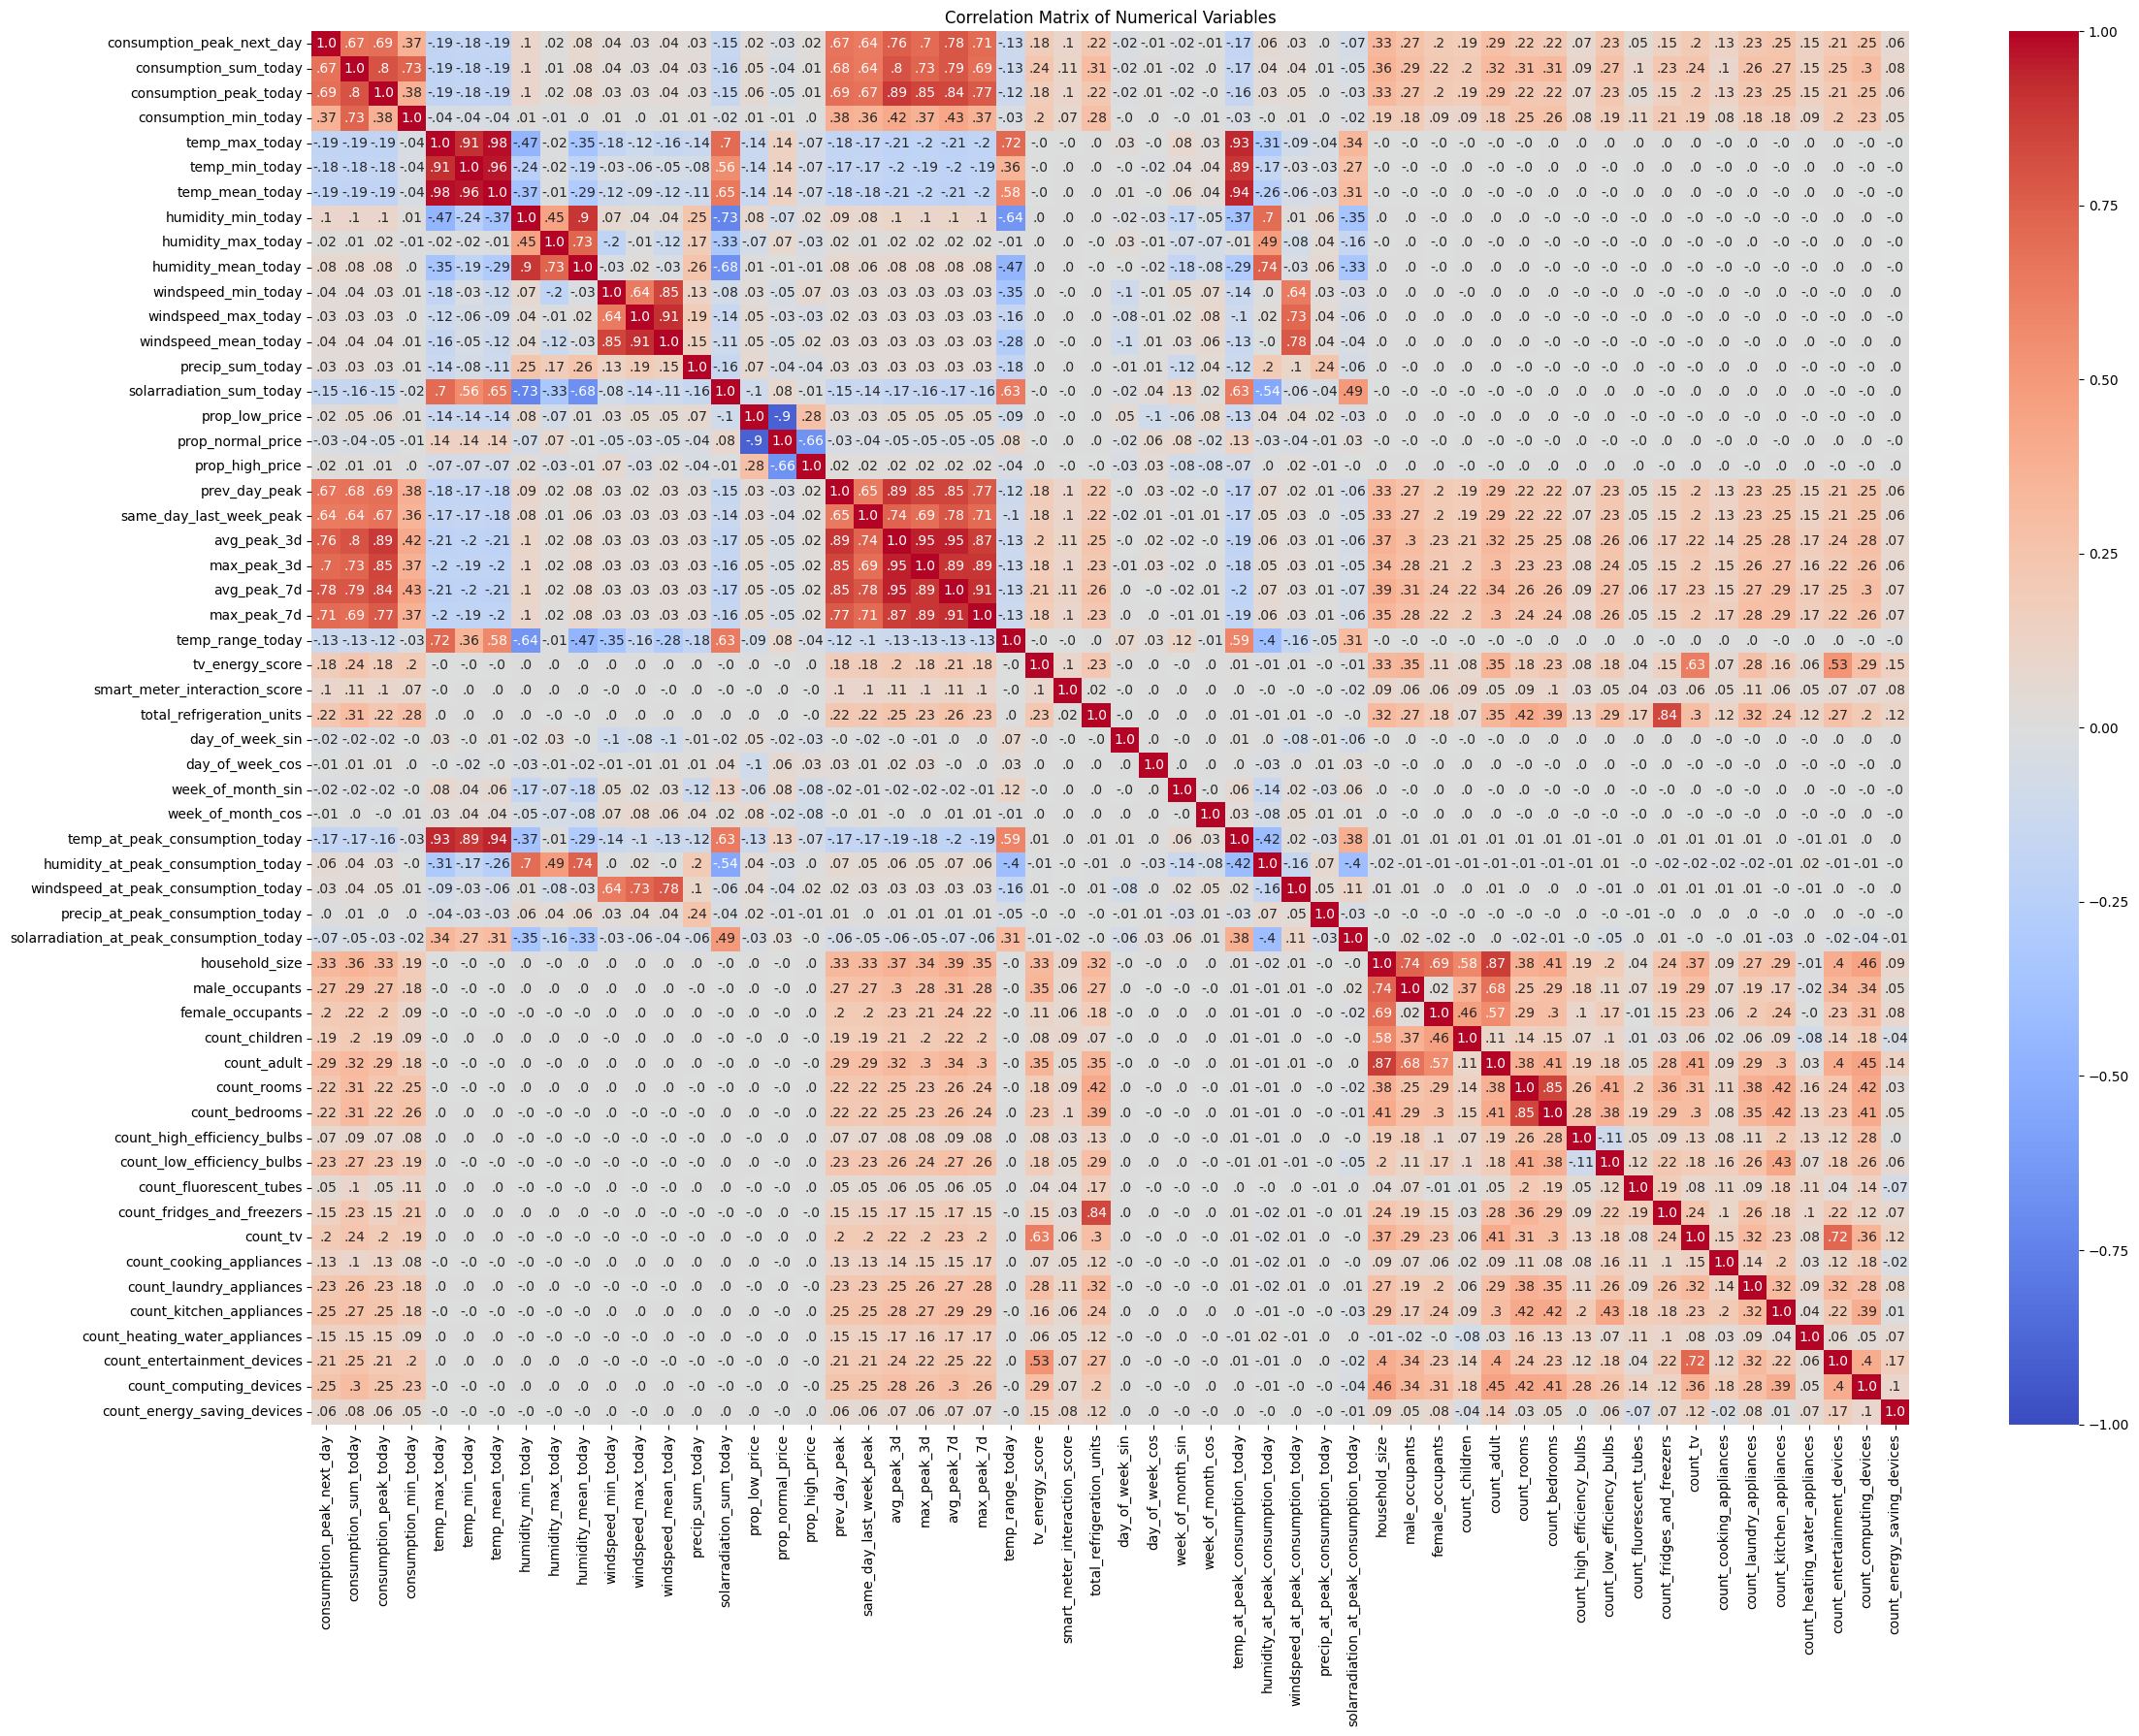

Highly correlated numerical features (correlation > 0.8):
consumption_peak_today and avg_peak_3d: 0.89
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    avg_peak_3d: 0.76

consumption_peak_today and max_peak_3d: 0.85
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    max_peak_3d: 0.70

consumption_peak_today and avg_peak_7d: 0.84
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    avg_peak_7d: 0.78

temp_max_today and temp_min_today: 0.91
  Correlation with consumption_peak_next_day:
    temp_max_today: -0.19
    temp_min_today: -0.18

temp_max_today and temp_mean_today: 0.98
  Correlation with consumption_peak_next_day:
    temp_max_today: -0.19
    temp_mean_today: -0.19

temp_max_today and temp_at_peak_consumption_today: 0.93
  Correlation with consumption_peak_next_day:
    temp_max_today: -0.19
    temp_at_peak_consumption_today: -0.17

temp_min_today and temp_mean_today: 0.96
  Correla

In [29]:
def process_numerical_correlations(df, numerical_vars, count_vars):
    def calculate_numerical_correlations(df, numerical_vars, count_vars):
        # Filter out variables not in the DataFrame
        valid_numerical_vars = [var for var in numerical_vars if var in df.columns]
        valid_count_vars = [var for var in count_vars if var in df.columns]
        
        # Select only the valid numerical variables
        num_df = df[valid_numerical_vars + valid_count_vars]
        
        # Calculate the correlation matrix
        corr_matrix = num_df.corr(method='pearson')
        
        return corr_matrix

    # Calculate correlations
    correlation_matrix = calculate_numerical_correlations(df, numerical_vars, count_vars)

    # Visualise the correlation matrix
    annot = correlation_matrix.round(2).astype(str)

    # Function to format the correlation values
    def format_corr(val):
        if val.startswith('-0.'):
            return '-' + val[2:]
        val = val.lstrip('0')
        if val == '.00' or val == '-.00':
            return '0'
        elif val.startswith('-.'):
            return '-' + val[2:]
        elif val == '.':
            return '0'
        return val

    # Apply the formatting function
    annot = annot.map(format_corr)

    plt.figure(figsize=(24, 18))  
    sns.heatmap(correlation_matrix, annot=annot, fmt='', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.savefig('numerical_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Find highly correlated features
    high_corr_threshold = 0.8
    high_corr = np.where(np.abs(correlation_matrix) > high_corr_threshold)
    high_corr_list = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.loc[correlation_matrix.index[x], correlation_matrix.columns[y]]) 
                      for x, y in zip(*high_corr) if x != y and x < y]

    print("Highly correlated numerical features (correlation > 0.8):")
    for feat1, feat2, corr in high_corr_list:
        print(f"{feat1} and {feat2}: {corr:.2f}")
        
        # Compare correlations with the target variable (consumption_peak_next_day)
        corr_feat1 = correlation_matrix.loc[feat1, 'consumption_peak_next_day']
        corr_feat2 = correlation_matrix.loc[feat2, 'consumption_peak_next_day']
        
        print(f"  Correlation with consumption_peak_next_day:")
        print(f"    {feat1}: {corr_feat1:.2f}")
        print(f"    {feat2}: {corr_feat2:.2f}")
        print()

    low_corr_threshold = 0.1
    low_corr_features = [
        col for col in correlation_matrix.columns 
        if abs(correlation_matrix.loc['consumption_peak_next_day', col]) < low_corr_threshold
    ]

    print("Features with correlation less than 0.1 with consumption_peak_next_day:")
    for feature in low_corr_features:
        print(f"{feature}: {correlation_matrix.loc['consumption_peak_next_day', feature]:.2f}")

process_numerical_correlations(result_df, numerical_vars, count_vars)

### Let's explore the correlation between temperature and peak consumption (of today and next day) further

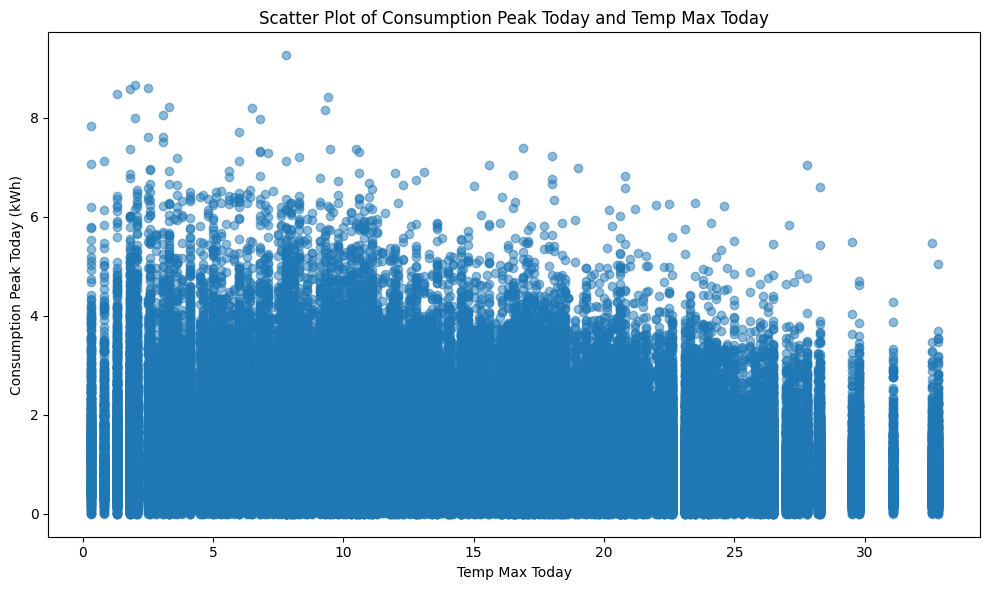

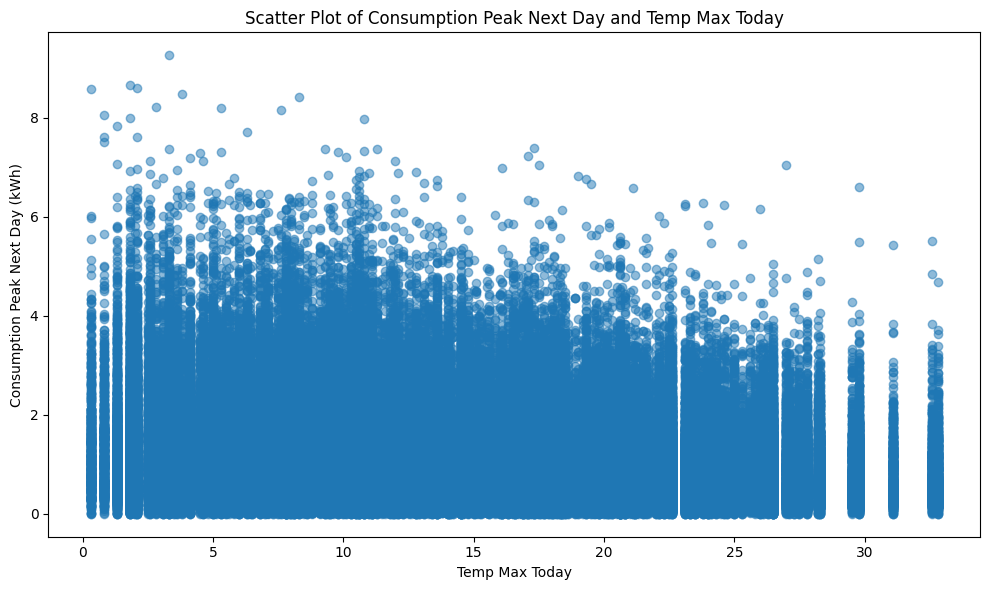

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(result_df['temp_max_today'], result_df['consumption_peak_today'], alpha=0.5)
plt.title('Scatter Plot of Consumption Peak Today and Temp Max Today')
plt.xlabel('Temp Max Today')
plt.ylabel('Consumption Peak Today (kWh)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(result_df['temp_max_today'], result_df['consumption_peak_next_day'], alpha=0.5)
plt.title('Scatter Plot of Consumption Peak Next Day and Temp Max Today')
plt.xlabel('Temp Max Today')
plt.ylabel('Consumption Peak Next Day (kWh)')
plt.tight_layout()
plt.show()

#### It seems that the relationship between temperature and peak consumption is non-linear. In addition to a weak negative trend, we can observe higher peaks at colder temperatures. This makes sense for the UK, where electricity consumption tends to be higher during colder weathers (for heating). In addition, the spread of consumption peaks is wider at lower temperatures, suggesting other factors influence consumption more when it's cold.

In [31]:
# Calculate correlation between temp_max and consumption_peak_next_day grouped by season to see if there's any meaningful relationship
seasonal_correlations = {}

for season_binary in ['is_summer', 'is_autumn', 'is_winter']:
    season_name = season_binary.split('_')[1].capitalize()
    season_data = result_df[result_df[season_binary] == 1]
    correlation = season_data['temp_max_today'].corr(season_data['consumption_peak_next_day'])
    seasonal_correlations[season_name] = correlation
    print(f"Correlation between temp_max_today and consumption_peak_next_day for {season_name}: {correlation:.2f}")

Correlation between temp_max_today and consumption_peak_next_day for Summer: -0.06
Correlation between temp_max_today and consumption_peak_next_day for Autumn: -0.12
Correlation between temp_max_today and consumption_peak_next_day for Winter: -0.05


### We will now drop variables less correlated with consumption_peak_next_day from each highly correlated pair
### Dropping features improved model performance during model development later (as opposed to keeping all features)

The following columns have been dropped:
['temp_min_today', 'temp_mean_today', 'temp_at_peak_consumption_today', 'humidity_mean_today', 'windspeed_mean_today', 'prop_normal_price', 'count_fridges_and_freezers', 'count_bedrooms', 'count_adult', 'smart_meter_interaction_score', 'count_high_efficiency_bulbs', 'count_fluorescent_tubes', 'count_energy_saving_devices']


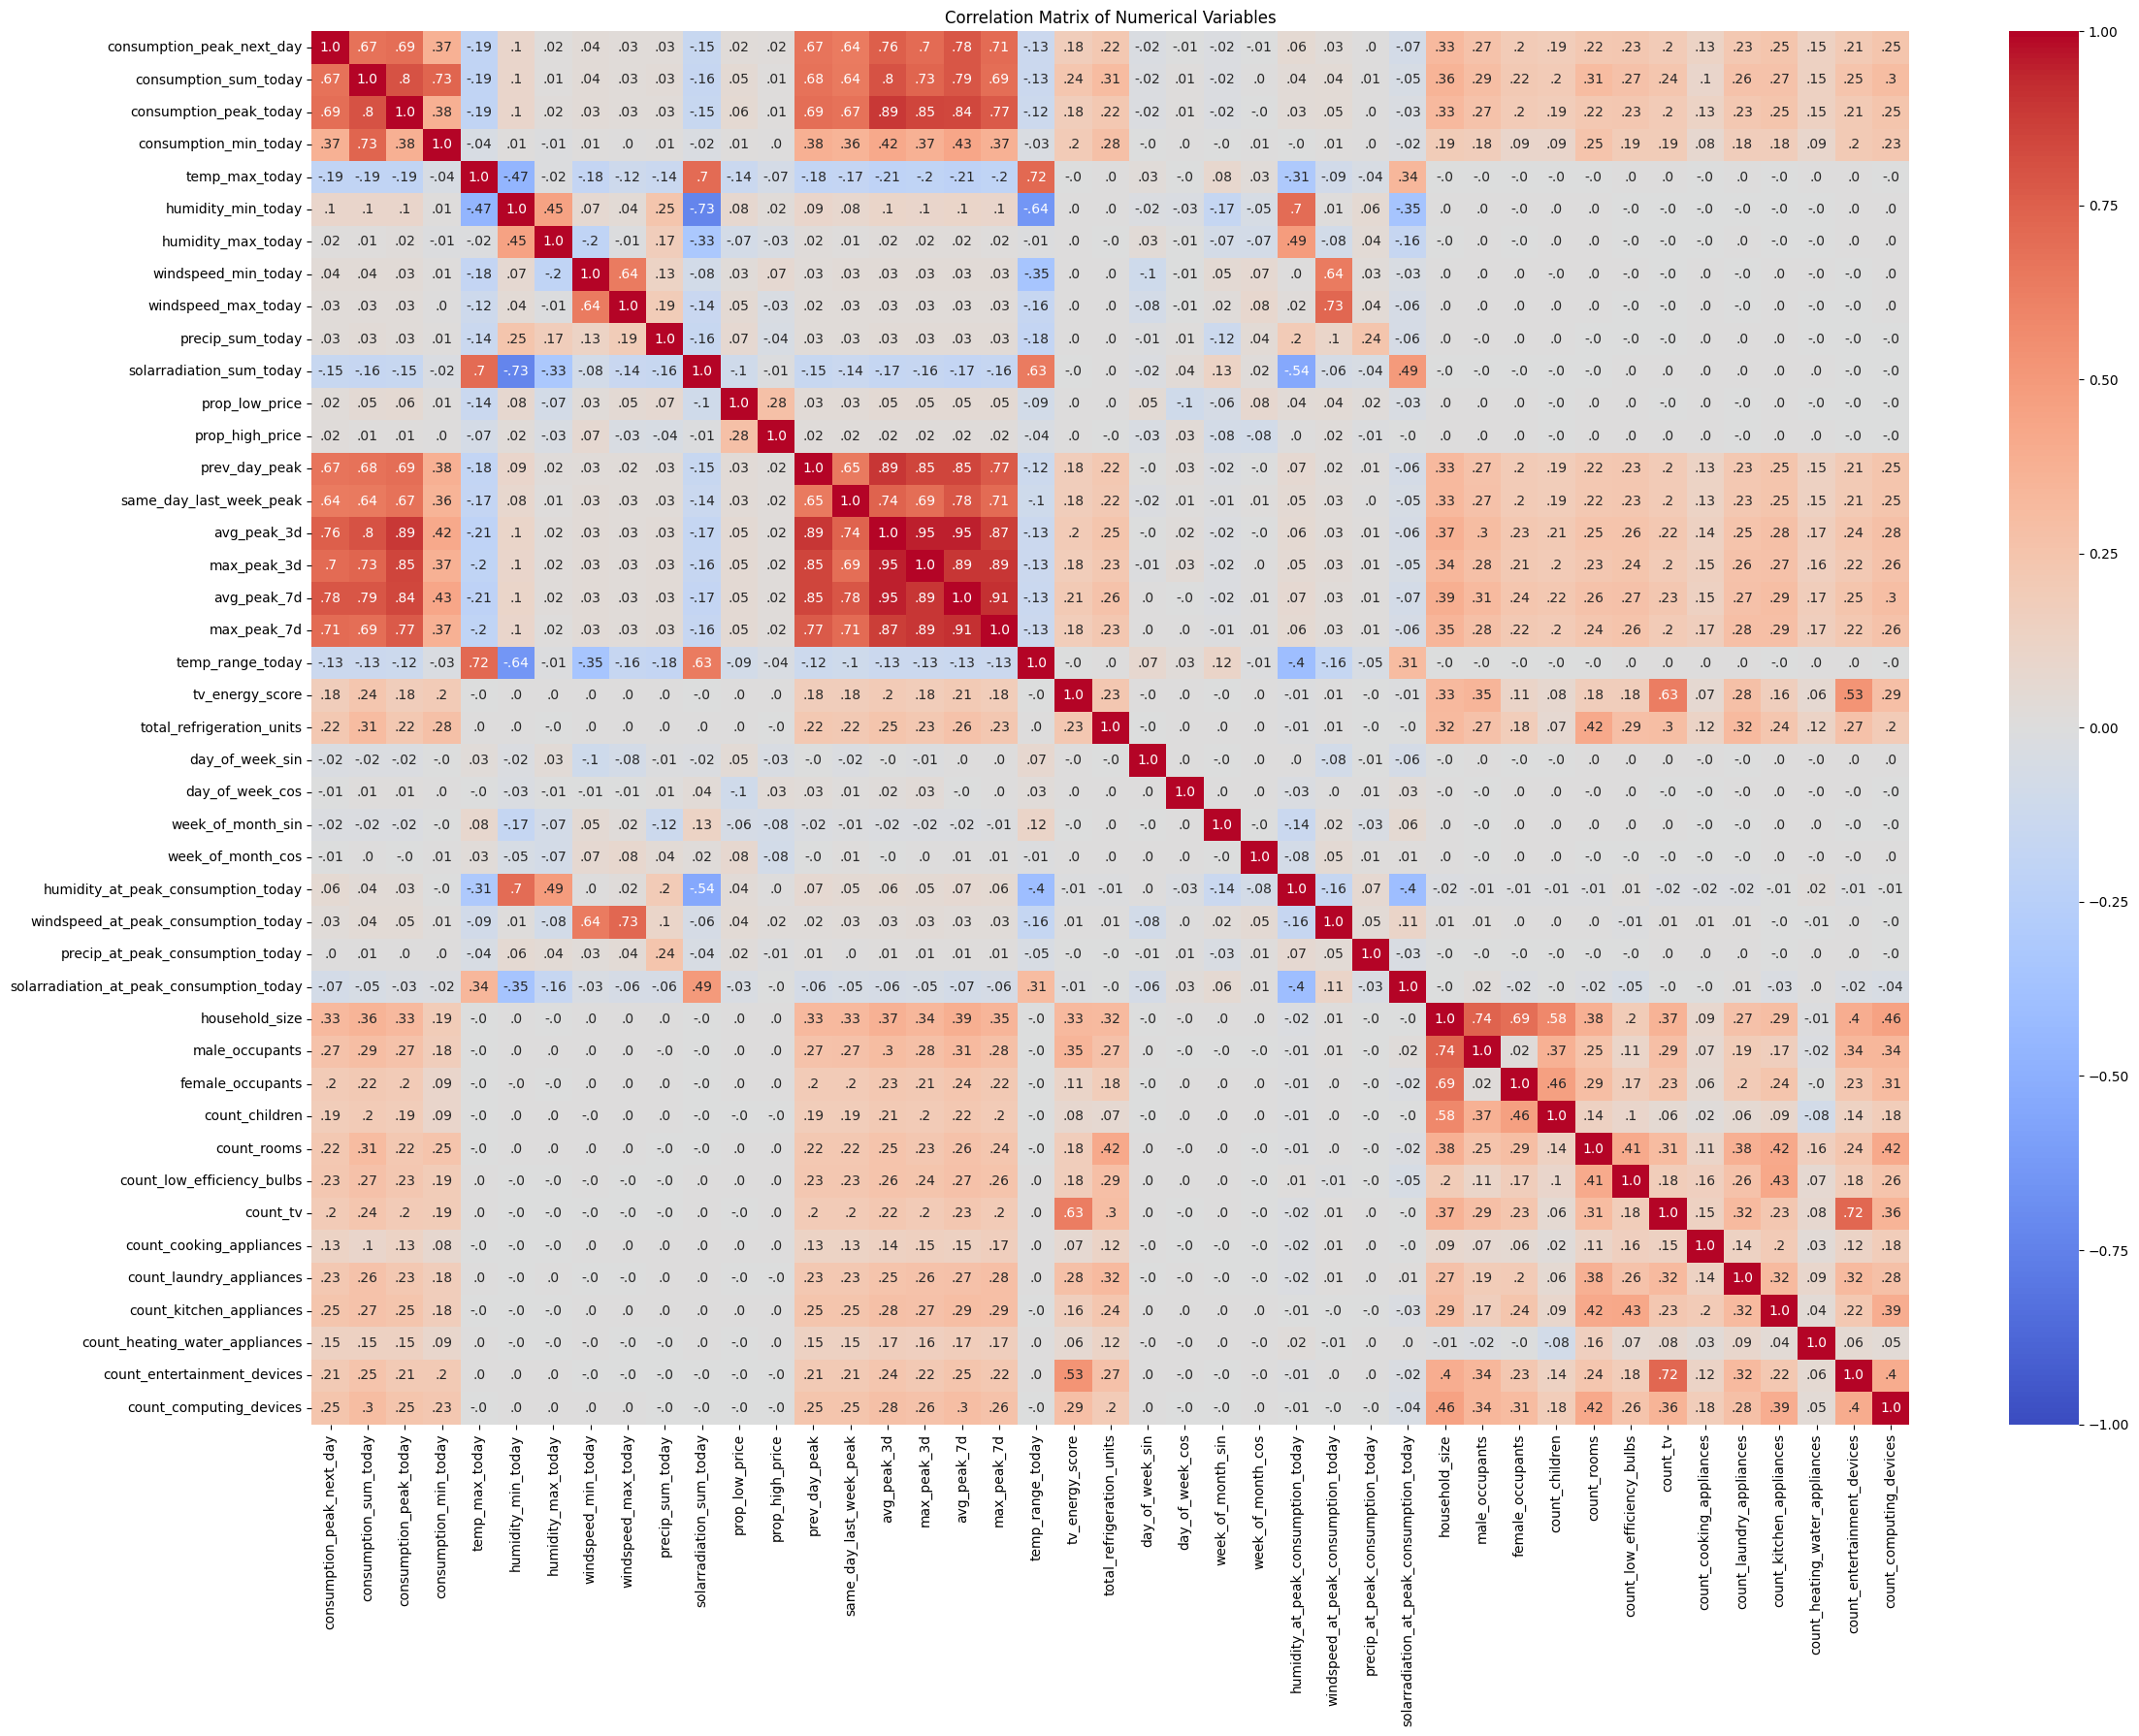

Highly correlated numerical features (correlation > 0.8):
consumption_peak_today and avg_peak_3d: 0.89
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    avg_peak_3d: 0.76

consumption_peak_today and max_peak_3d: 0.85
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    max_peak_3d: 0.70

consumption_peak_today and avg_peak_7d: 0.84
  Correlation with consumption_peak_next_day:
    consumption_peak_today: 0.69
    avg_peak_7d: 0.78

prev_day_peak and avg_peak_3d: 0.89
  Correlation with consumption_peak_next_day:
    prev_day_peak: 0.67
    avg_peak_3d: 0.76

prev_day_peak and max_peak_3d: 0.85
  Correlation with consumption_peak_next_day:
    prev_day_peak: 0.67
    max_peak_3d: 0.70

prev_day_peak and avg_peak_7d: 0.85
  Correlation with consumption_peak_next_day:
    prev_day_peak: 0.67
    avg_peak_7d: 0.78

avg_peak_3d and max_peak_3d: 0.95
  Correlation with consumption_peak_next_day:
    avg_peak_3d: 0.76
    max_peak

In [32]:
# We will keep 'consumption_peak_today', 'avg_peak_3d', 'max_peak_3d', 'avg_peak_7d', 'max_peak_7d' and 'prev_day_peak' despite high correlations as each feature likely provides valuable information for the next day's peak consumption
columns_to_drop = [
    'temp_min_today', 'temp_mean_today', 'temp_at_peak_consumption_today', 'humidity_mean_today', 'windspeed_mean_today', 
    'prop_normal_price', 'count_fridges_and_freezers', 'count_bedrooms', 'count_adult'
]

# As for features that have a low correlation with consumption_peak_next_day, we're only dropping household features because other features may have non-linear relationships not captured by the correlation coefficient.
columns_to_drop.extend([
    'smart_meter_interaction_score',
    'count_high_efficiency_bulbs',
    'count_fluorescent_tubes',
    'count_energy_saving_devices'
])

# Drop the selected columns from the DataFrame
result_df = result_df.drop(columns=columns_to_drop)

print("The following columns have been dropped:")
print(columns_to_drop)

### Reiterate the process (Check the correlations again)
process_numerical_correlations(result_df, numerical_vars, count_vars)

### Now we will check the correlations among categorical variables as well as the mutual information between each one and the target variable.

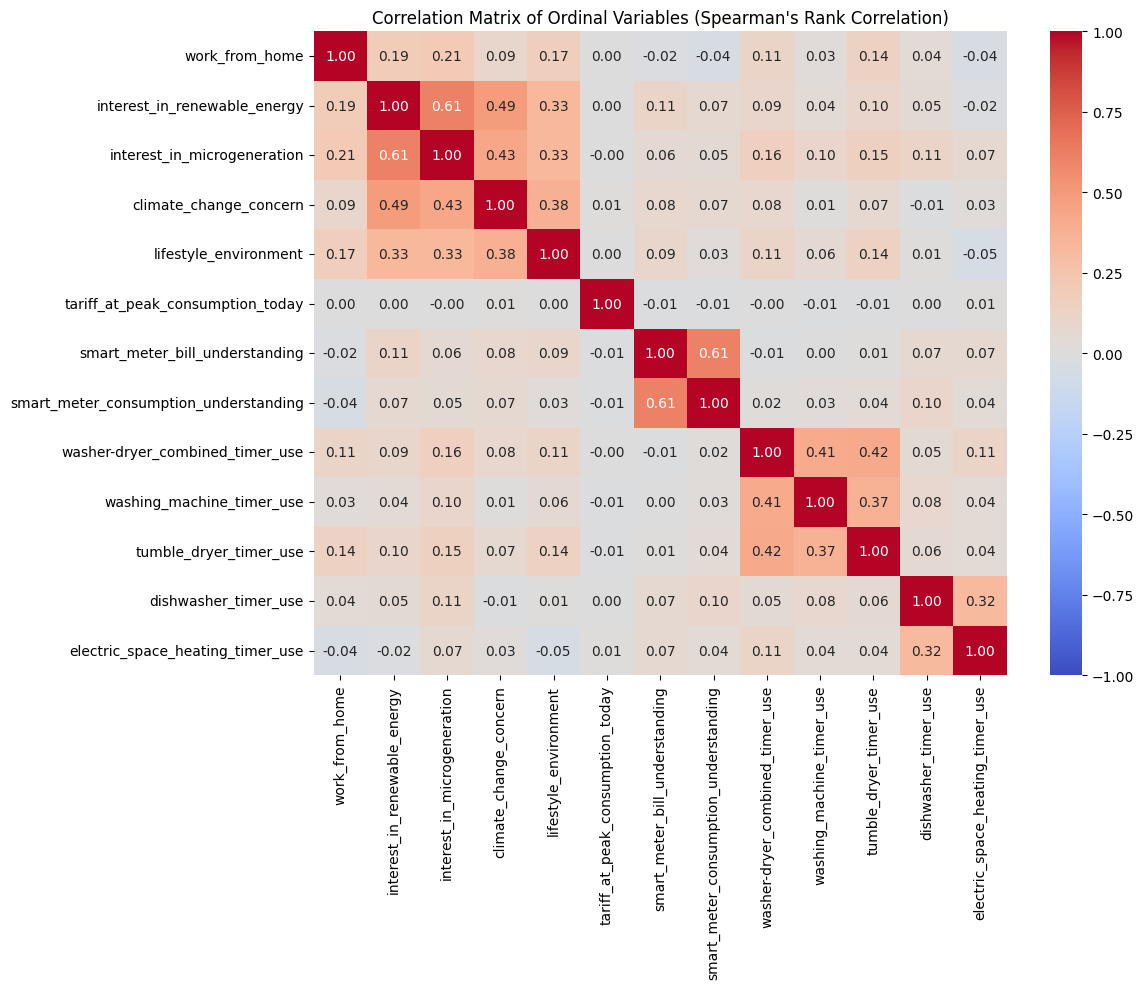

In [33]:
def spearman_correlation(x, y):
    try:
        return round(spearmanr(x, y)[0], 2)
    except:
        return np.nan

def ordinal_correlation_matrix(df, ordinal_vars):
    corr_matrix = pd.DataFrame(index=ordinal_vars, columns=ordinal_vars)
    for i in ordinal_vars:
        for j in ordinal_vars:
            corr_matrix.loc[i, j] = spearman_correlation(df[i], df[j])
    return corr_matrix.astype(float)

# All the categorical variables are ordinal
ordinal_corr_matrix = ordinal_correlation_matrix(result_df, categorical_vars)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(ordinal_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, 
            mask=np.isnan(ordinal_corr_matrix))
plt.title('Correlation Matrix of Ordinal Variables (Spearman\'s Rank Correlation)')
plt.tight_layout()
plt.savefig('ordinal_correlation_matrix.png')
plt.show()

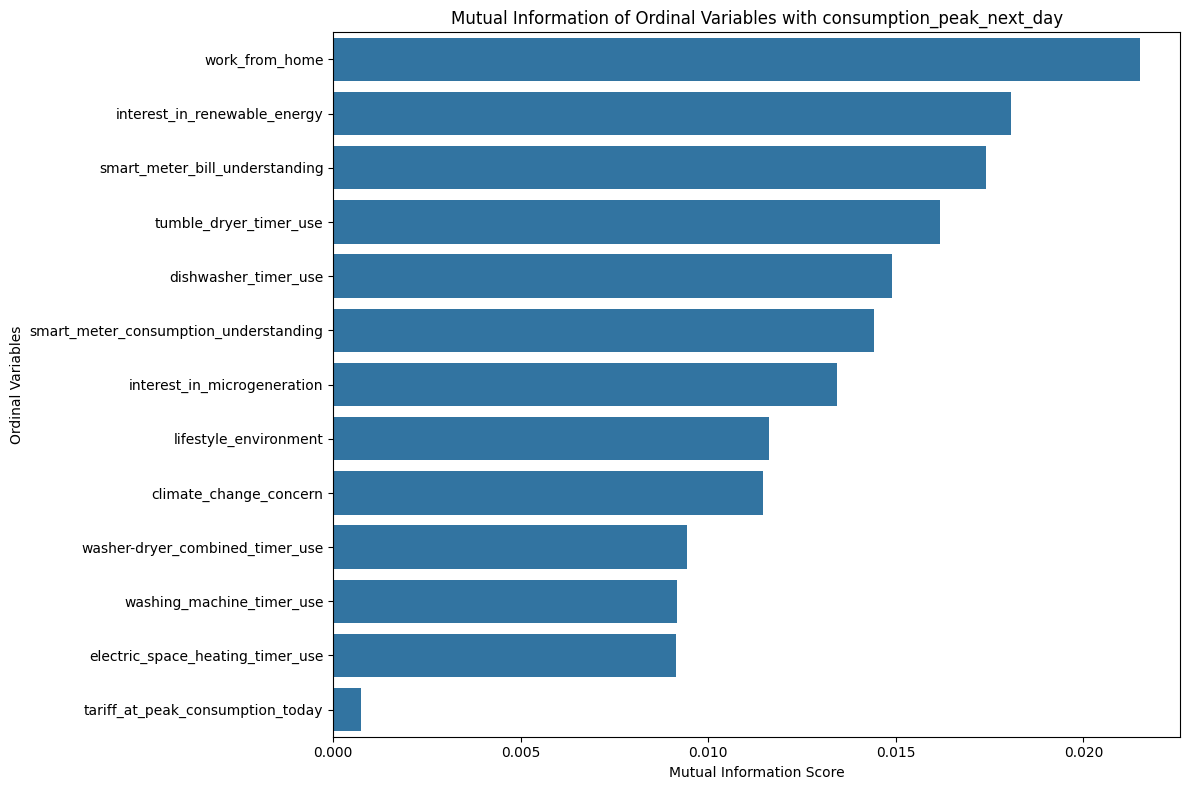

In [34]:
def mutual_info_with_target(df, ordinal_vars, target):
    mi_scores = mutual_info_regression(df[ordinal_vars], df[target])
    mi_df = pd.DataFrame({'Variable': ordinal_vars, 'Mutual Information': mi_scores})
    mi_df = mi_df.sort_values('Mutual Information', ascending=False)
    return mi_df

target_correlations = mutual_info_with_target(result_df, categorical_vars, 'consumption_peak_next_day')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Variable', data=target_correlations)
plt.title('Mutual Information of Ordinal Variables with consumption_peak_next_day')
plt.xlabel('Mutual Information Score')
plt.ylabel('Ordinal Variables')
plt.tight_layout()
plt.savefig('mutual_information_plot.png')
plt.show()

### None of the categorical variables have very strong (and problematic) correlations, and they all have some correlation with the target variable, so we will not eliminate any of them.

### Let's create a few more plots to explore the data

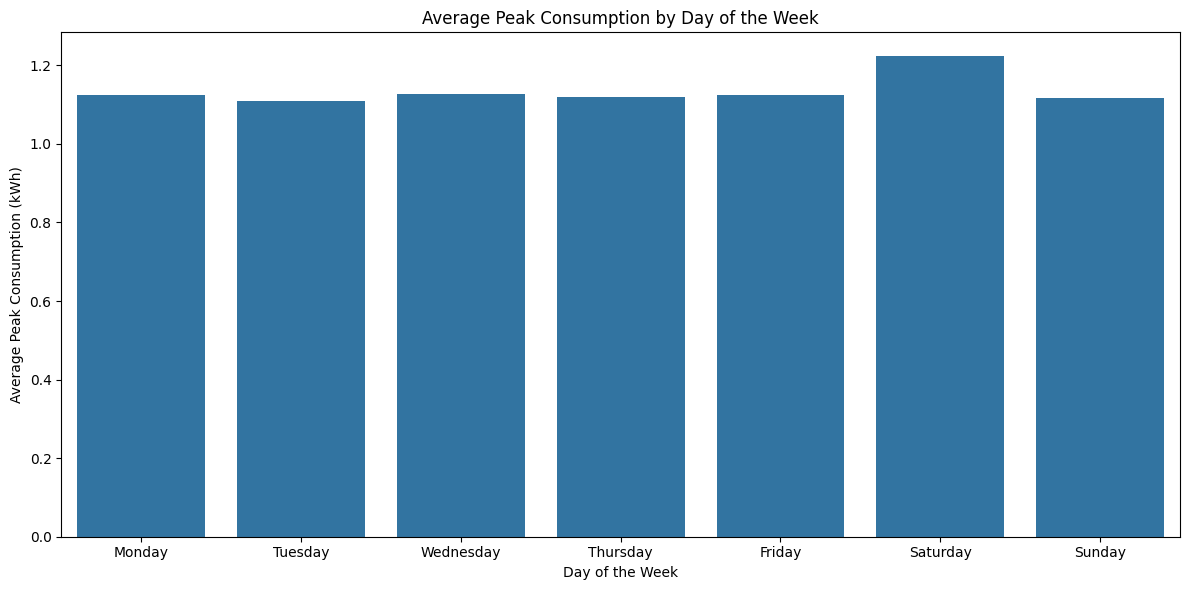


Summary statistics for Average Peak Consumption by Day of the Week:
               count      mean       std  min    25%     50%      75%    max
day_of_week                                                                 
Monday       31008.0  1.125509  0.849857  0.0  0.503  0.9360  1.50700  8.600
Tuesday      31008.0  1.109487  0.846213  0.0  0.491  0.9100  1.48300  7.358
Wednesday    31008.0  1.126374  0.848620  0.0  0.500  0.9380  1.51825  8.163
Thursday     31008.0  1.118707  0.842757  0.0  0.495  0.9350  1.50300  8.209
Friday       31008.0  1.125247  0.866333  0.0  0.482  0.9300  1.52700  9.260
Saturday     31008.0  1.223001  0.933359  0.0  0.514  1.0210  1.67000  7.830
Sunday       31008.0  1.117030  0.841766  0.0  0.501  0.9245  1.49800  8.662


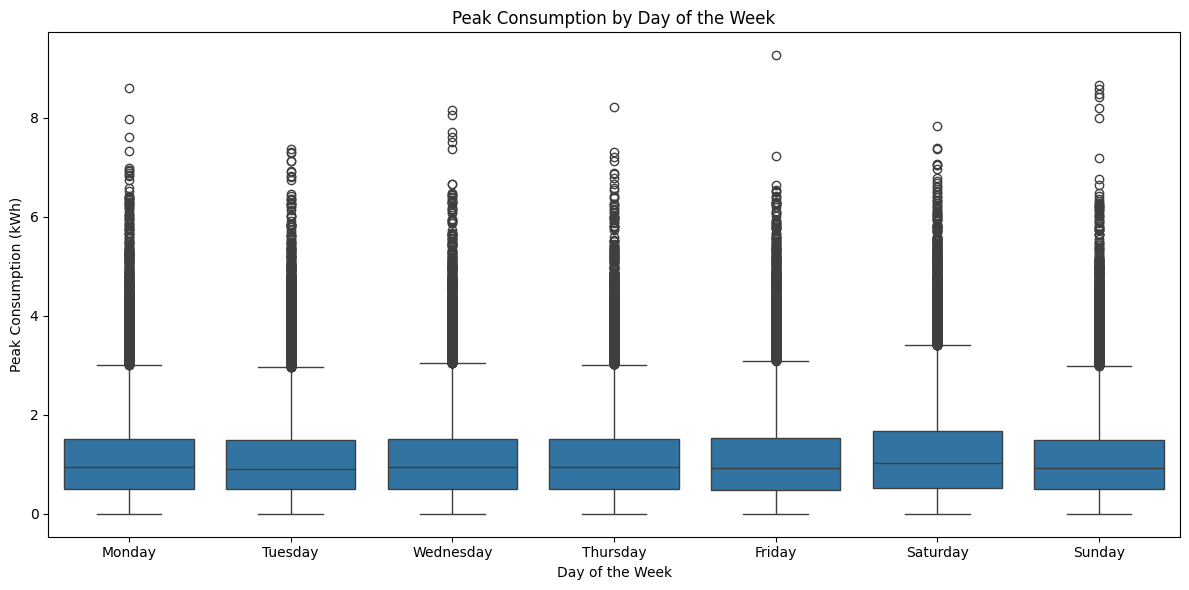


Summary statistics for Peak Consumption by Day of the Week:
               count      mean       std  min    25%     50%      75%    max
day_of_week                                                                 
Friday       31008.0  1.125247  0.866333  0.0  0.482  0.9300  1.52700  9.260
Monday       31008.0  1.125509  0.849857  0.0  0.503  0.9360  1.50700  8.600
Saturday     31008.0  1.223001  0.933359  0.0  0.514  1.0210  1.67000  7.830
Sunday       31008.0  1.117030  0.841766  0.0  0.501  0.9245  1.49800  8.662
Thursday     31008.0  1.118707  0.842757  0.0  0.495  0.9350  1.50300  8.209
Tuesday      31008.0  1.109487  0.846213  0.0  0.491  0.9100  1.48300  7.358
Wednesday    31008.0  1.126374  0.848620  0.0  0.500  0.9380  1.51825  8.163


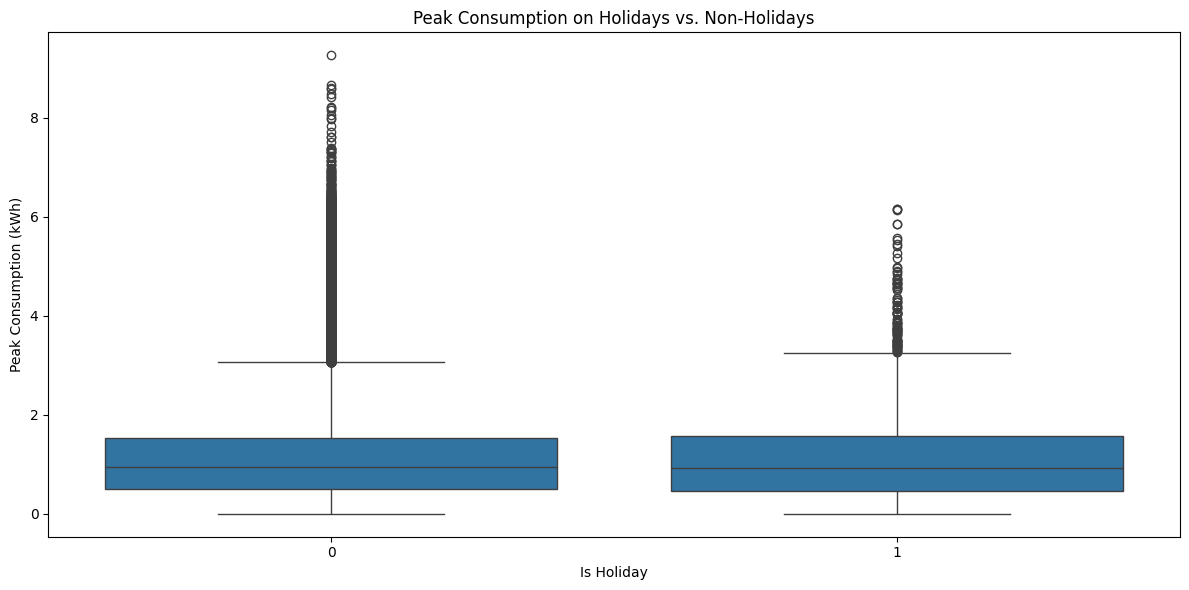


Summary statistics for Peak Consumption on Holidays vs. Non-Holidays:
               count      mean       std  min      25%     50%    75%    max
is_holiday                                                                  
0           214016.0  1.135021  0.861725  0.0  0.49800  0.9410  1.527  9.260
1             3040.0  1.137120  0.919698  0.0  0.45275  0.9175  1.578  6.161


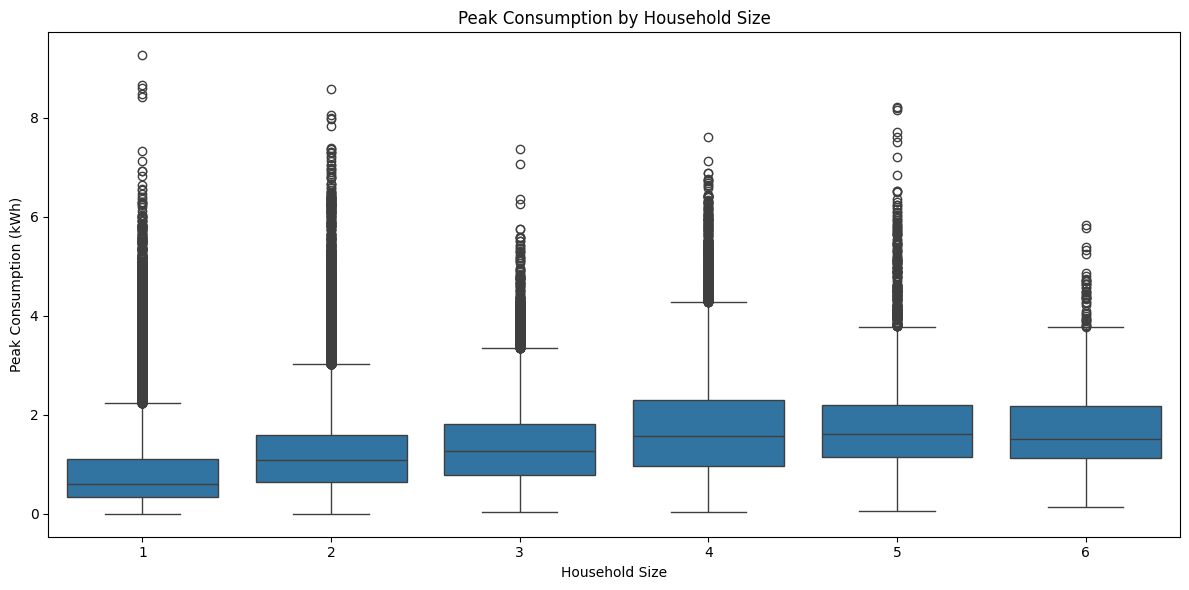


Summary statistics for Peak Consumption by Household Size:
                  count      mean       std    min    25%    50%     75%  \
household_size                                                             
1               89607.0  0.837820  0.756148  0.000  0.339  0.603  1.1000   
2               82467.0  1.225337  0.813368  0.000  0.644  1.081  1.5940   
3               23919.0  1.384994  0.795456  0.038  0.781  1.264  1.8090   
4               15351.0  1.754186  1.037237  0.031  0.969  1.562  2.2935   
5                4641.0  1.791180  1.012882  0.056  1.149  1.611  2.2020   
6                1071.0  1.751706  0.927363  0.141  1.124  1.517  2.1810   

                  max  
household_size         
1               9.260  
2               8.578  
3               7.375  
4               7.615  
5               8.209  
6               5.834  


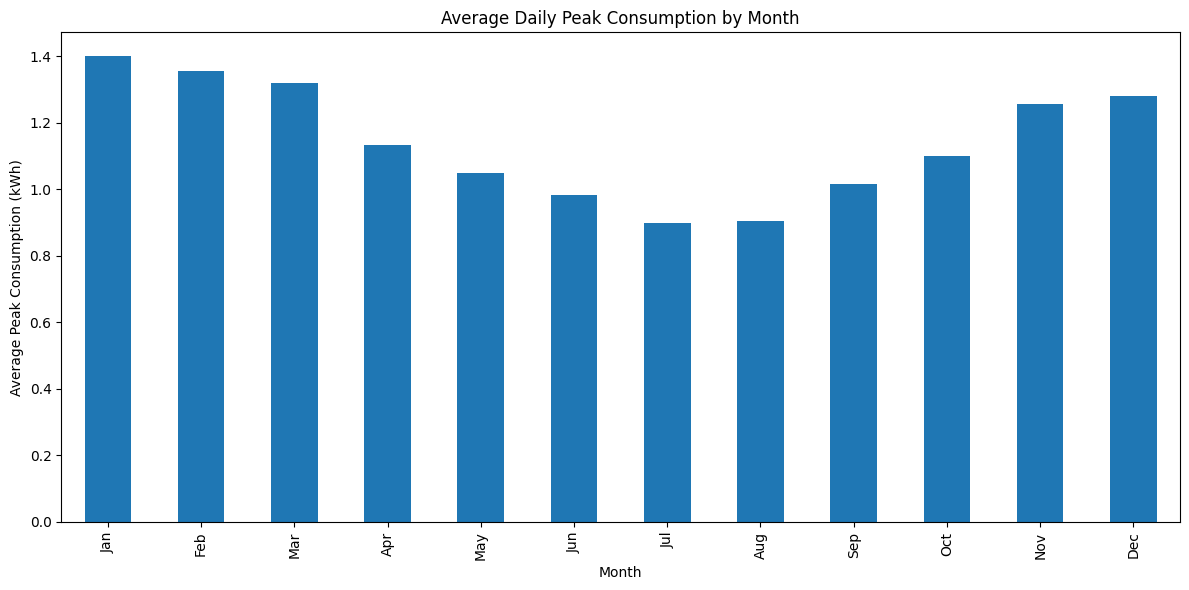


Summary statistics for Average Daily Peak Consumption by Month:
         count      mean       std  min    25%    50%      75%    max
month                                                                
1      14592.0  1.402226  1.006131  0.0  0.659  1.185  1.85325  9.260
2      17024.0  1.357453  1.009376  0.0  0.605  1.133  1.80925  8.600
3      18848.0  1.319150  0.987692  0.0  0.584  1.107  1.76200  8.662
4      18240.0  1.132899  0.841555  0.0  0.500  0.949  1.53200  6.562
5      18848.0  1.050335  0.793968  0.0  0.455  0.869  1.41900  6.911
6      18240.0  0.983649  0.739354  0.0  0.431  0.815  1.35000  7.044
7      18848.0  0.898900  0.669178  0.0  0.405  0.736  1.22400  7.042
8      18848.0  0.904197  0.696161  0.0  0.391  0.735  1.24100  6.277
9      18240.0  1.015522  0.766783  0.0  0.446  0.842  1.38900  7.395
10     18848.0  1.101584  0.781457  0.0  0.512  0.939  1.50100  6.687
11     18240.0  1.255528  0.886574  0.0  0.600  1.074  1.67200  6.712
12     18240.0  1.280796 

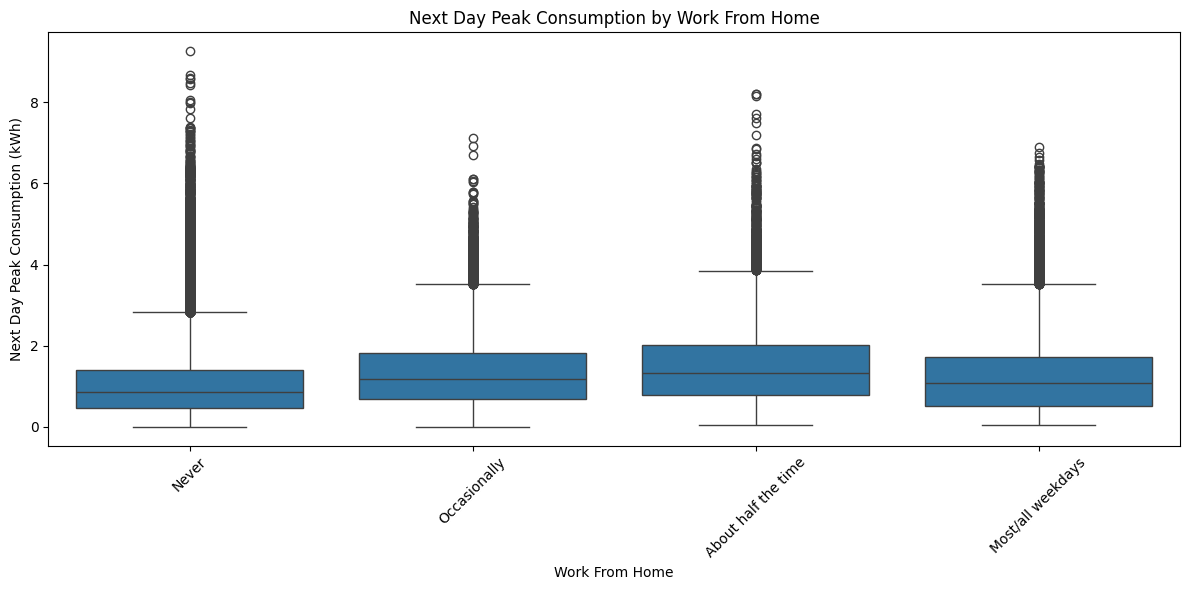


Summary statistics for Next Day Peak Consumption by Work From Home:
                          count      mean       std    min    25%    50%  \
work_from_home_mapped                                                      
Never                  159222.0  1.048787  0.808936  0.000  0.462  0.857   
Occasionally            33558.0  1.342946  0.879085  0.000  0.678  1.186   
About half the time     11781.0  1.527842  1.030621  0.047  0.792  1.328   
Most/all weekdays       12495.0  1.305606  1.060059  0.047  0.506  1.083   

                         75%    max  
work_from_home_mapped                
Never                  1.410  9.260  
Occasionally           1.812  7.130  
About half the time    2.017  8.209  
Most/all weekdays      1.709  6.887  


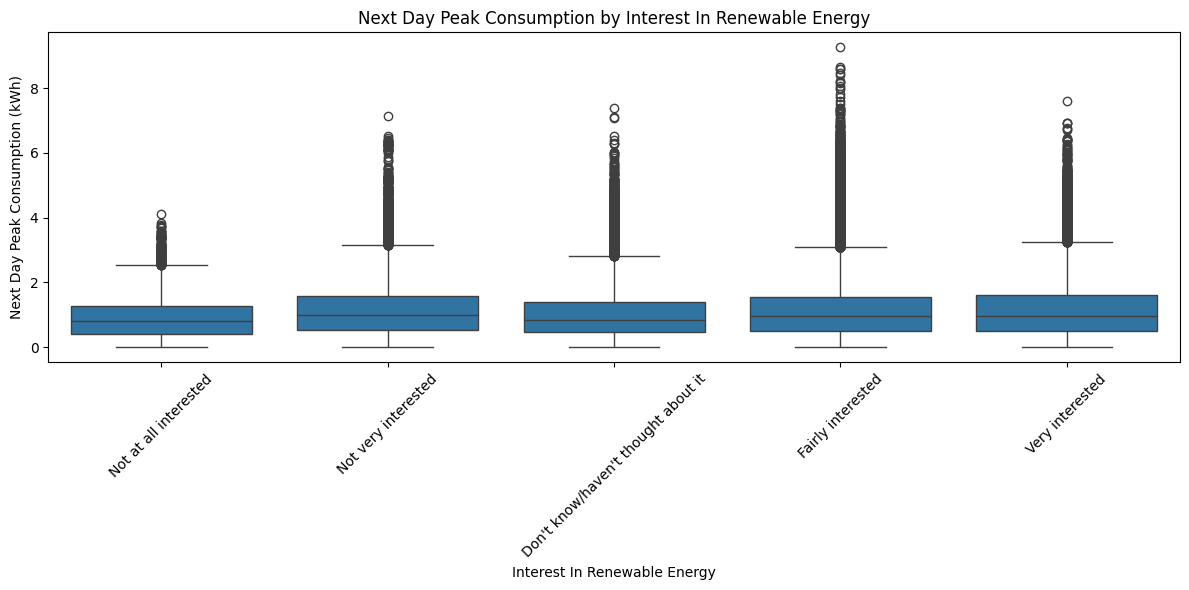


Summary statistics for Next Day Peak Consumption by Interest In Renewable Energy:
                                       count      mean       std    min  \
interest_in_renewable_energy_mapped                                       
Not at all interested                 8568.0  0.893795  0.591856  0.000   
Not very interested                  24633.0  1.160093  0.870088  0.000   
Don't know/haven't thought about it  32487.0  1.043172  0.811066  0.001   
Fairly interested                    84966.0  1.160506  0.885969  0.000   
Very interested                      66402.0  1.169270  0.875179  0.000   

                                       25%    50%      75%    max  
interest_in_renewable_energy_mapped                                
Not at all interested                0.414  0.812  1.25825  4.116  
Not very interested                  0.518  0.989  1.57300  7.130  
Don't know/haven't thought about it  0.466  0.832  1.40700  7.375  
Fairly interested                    0.511  0.970  

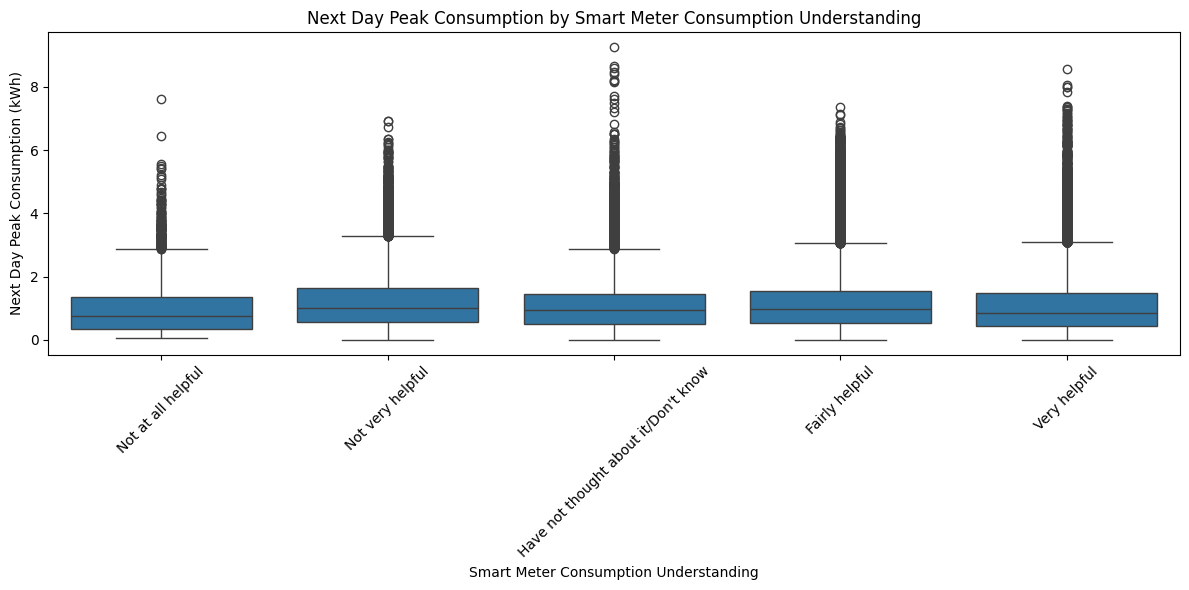


Summary statistics for Next Day Peak Consumption by Smart Meter Consumption Understanding:
                                                count      mean       std  \
smart_meter_consumption_understanding_mapped                                
Not at all helpful                             7140.0  0.945664  0.763259   
Not very helpful                              28560.0  1.221801  0.875885   
Have not thought about it/Don't know          28560.0  1.073465  0.794216   
Fairly helpful                                95676.0  1.165693  0.869035   
Very helpful                                  57120.0  1.094816  0.881572   

                                                min    25%    50%    75%  \
smart_meter_consumption_understanding_mapped                               
Not at all helpful                            0.056  0.345  0.748  1.360   
Not very helpful                              0.010  0.564  1.023  1.653   
Have not thought about it/Don't know          0.000  0.490  0.93

In [35]:
# Create day of the week variable and order
result_df['day_of_week'] = pd.to_datetime(result_df['date']).dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def plot_boxplot(x, y, data, title, xlabel, ylabel, order=None, rotation=0):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=x, y=y, data=data, order=order)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f'{ylabel} (kWh)')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()
    print(f"\nSummary statistics for {title}:")
    print(data.groupby(x, observed=False)[y].describe())

# Average peak consumption by day of the week
avg_peak_by_day = result_df.groupby('day_of_week')['consumption_peak_next_day'].mean().reindex(days_order)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_peak_by_day.index, y=avg_peak_by_day.values, order=days_order)
plt.title('Average Peak Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Peak Consumption (kWh)')
plt.tight_layout()
plt.show()
print("\nSummary statistics for Average Peak Consumption by Day of the Week:")
print(result_df.groupby('day_of_week', observed=False)['consumption_peak_next_day'].describe().reindex(days_order))

# Peak consumption by day of the week
plot_boxplot('day_of_week', 'consumption_peak_next_day', result_df, 
             'Peak Consumption by Day of the Week', 'Day of the Week', 'Peak Consumption', 
             order=days_order)

# Peak consumption on holidays vs. non-holidays
plot_boxplot('is_holiday', 'consumption_peak_next_day', result_df, 
             'Peak Consumption on Holidays vs. Non-Holidays', 'Is Holiday', 'Peak Consumption')

# Peak consumption by household size
plot_boxplot('household_size', 'consumption_peak_next_day', result_df, 
             'Peak Consumption by Household Size', 
             'Household Size', 'Peak Consumption')

# Monthly average peak consumption
result_df['month'] = pd.to_datetime(result_df['date']).dt.month
monthly_avg_peak = result_df.groupby('month')['consumption_peak_next_day'].mean()
plt.figure(figsize=(12, 6))
monthly_avg_peak.plot(kind='bar')
plt.title('Average Daily Peak Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Peak Consumption (kWh)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()
print("\nSummary statistics for Average Daily Peak Consumption by Month:")
print(result_df.groupby('month', observed=False)['consumption_peak_next_day'].describe())

# Function to plot and summarize for categorical variables
def plot_and_summarize(x, y, data, title, mapping):
    data[f'{x}_mapped'] = data[x].map(mapping)
    categories = [mapping[k] for k in sorted(mapping.keys()) if k in data[x].unique()]
    plot_boxplot(f'{x}_mapped', y, data, f'Next Day Peak Consumption by {title}', title, 'Next Day Peak Consumption', order=categories, rotation=45)
    data.drop(f'{x}_mapped', axis=1, inplace=True)

# Mappings
mappings = {
    'work_from_home': {0.0: 'Never', 1.0: 'Occasionally', 2.0: 'About half the time', 3.0: 'Most/all weekdays'},
    'interest_in_renewable_energy': {0.0: 'Not at all interested', 1.0: 'Not very interested', 2.0: "Don't know/haven't thought about it", 3.0: 'Fairly interested', 4.0: 'Very interested'},
    'smart_meter_consumption_understanding': {0.0: 'Not at all helpful', 1.0: 'Not very helpful', 2.0: 'Have not thought about it/Don\'t know', 3.0: 'Fairly helpful', 4.0: 'Very helpful'}
}

# Plot for each categorical variable
for var, mapping in mappings.items():
    plot_and_summarize(var, 'consumption_peak_next_day', result_df, var.replace('_', ' ').title(), mapping)

# Clean up temporary columns
result_df.drop(['day_of_week', 'month'], axis=1, inplace=True)

### Also create a correlation matrix with just a few selected columns

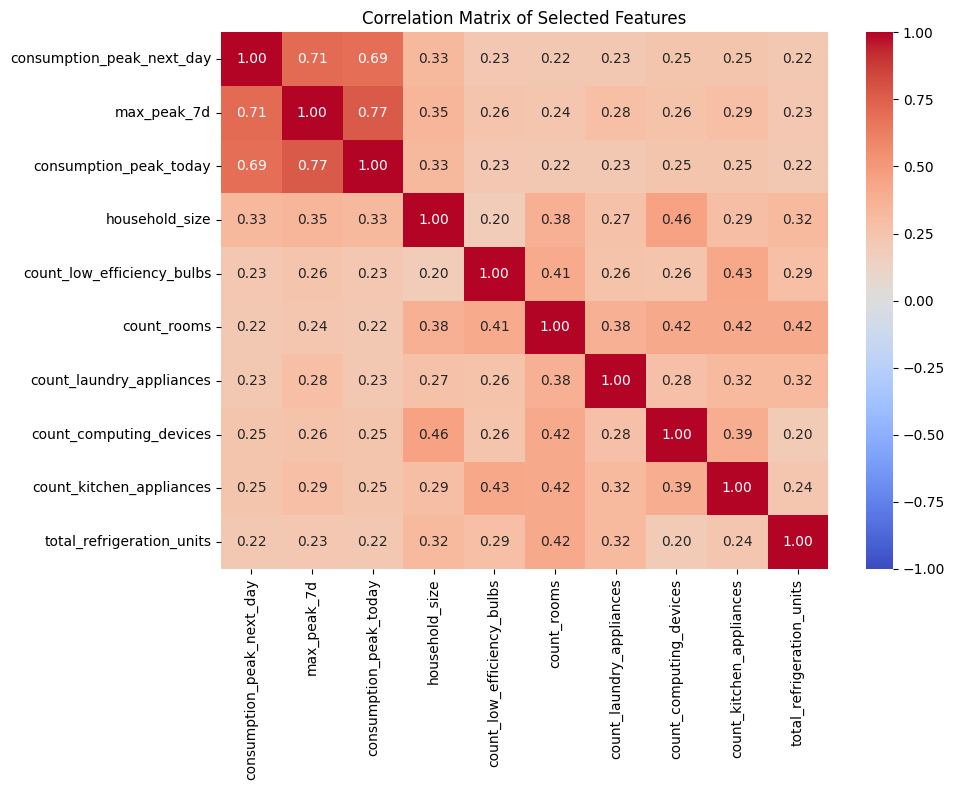

In [36]:
selected_columns = [
    'consumption_peak_next_day',
    'max_peak_7d',
    'consumption_peak_today',
    'household_size',
    'count_low_efficiency_bulbs',
    'count_rooms',
    'count_laundry_appliances',
    'count_computing_devices',
    'count_kitchen_appliances',
    'total_refrigeration_units'
]

plt.figure(figsize=(10, 8))
sns.heatmap(result_df[selected_columns].corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.savefig('selected_features_correlation_matrix.png')
plt.show()

In [37]:
# Save the full DataFrame
result_df.to_csv('6) daily_consumption_data_full.csv', index=False)
print("Full data saved to '6) daily_consumption_data_full.csv'")

Full data saved to '6) daily_consumption_data_full.csv'
